# Mineral diffusion timescales

## 1. Determination of diffusion timescales
SEM has been used to determine the concentration of certain elements (Fe, Mg).  These elements will diffuse away from crystals according to
\begin{equation}\label{eq:diffusion_eqn}
    \dfrac{\partial C}{\partial t} - \dfrac{\partial}{\partial x} \left( D(T)\dfrac{\partial C}{\partial x} \right) = 0,
\end{equation}

\noindent where $C(x, t)$ is the concentration of a species at a location, $x$, and time, $t$.  The diffusivity, $D$, depends strongly on temperature, $T$, and we may write, in general ([wiki](https://en.wikipedia.org/wiki/Mass_diffusivity))

\begin{equation}\label{eq:diffusivity}
    D(T) = D_0 \exp \left(-\frac{E_A}{R T}\right),
\end{equation}

\noindent where $E_A$ is the activation energy, $R$ is the universal gas constant and $D_0$ is the diffusivity at infinite temperature.  These parameters are assumed to be constants.

If $T$ is constant during the diffusion process (is it reasonable to assume that the cooling timescale is much longer than the diffusion timescale?), then an analytical solution to (\ref{eq:diffusion_eqn}) is 
\begin{equation}\label{eq:analytical_soln}
    C(x, t) = C_2 + \dfrac{C_1 - C_2}{2} \text{erfc} \left( \dfrac{x}{2 \sqrt{D t}}. \right)
\end{equation}

In the first part of this code, we take some sample data and fit this model.  This process can also be run recursively over all the SEM traverse data.

In [1]:
# Standard libraries
from functools import partial
from glob import glob
from scipy.special import erfc, gammaln, polygamma, gamma
from scipy.stats import expon, kstest, norm, chi2 
from scipy.stats import gamma as gamma_distn
from scipy.optimize import curve_fit, newton, fmin
from scipy.constants import R  # Ideal-gas constant
from matplotlib.ticker import MultipleLocator

import pandas as pd # Use pandas' inherrent excel support, rather than numpy
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Import functions from local module
from diffusion_timescale_modelling.diffusion_timescale_modelling import (
    opx_model, diffusion_coeff, temp_from_diff_coeff, analytical_soln, 
    fit_wrapper, plot_data_model, read_raw_data, coefficient_determination)

E   = -308000    # Activation energy
fO2 = 6.31e-7    # O2 partial pressure in Pa as determined from Ni-NiO buffer with dNNO = 0.8, and T ~ 900 °C
D0  = opx_model(fO2) # Base diffusion coefficient in m2/s
T   =  1297 #81.75   # Melt matrix temperature, defined by Dohmen et al., 2016
print(r'D0 = %.4g m$^2$/s' % D0)

D0 = 5.256e-07 m$^2$/s


Keep this line if you want to cycle through the entire dataset (which
could take a while).  Otherwise, comment out these next two lines and 
uncomment the line below.  If running recursively over all data, comment 
out the last-but-one line 
"fig.show()", 
and uncomment the last line: 
"fig.savefig"

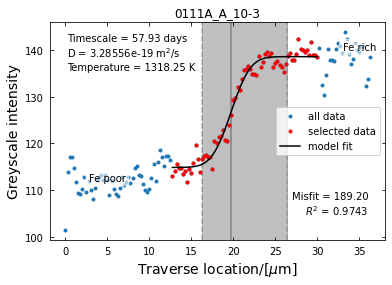

In [3]:
# Run the fitting routine on the entire dataset (or some subset of this), and
# produce plots of the model fitted to the data for each traverse.

# filenames = [f for f in sorted(glob('SEM_traverse_data/**', recursive=True)) 
#              if f.endswith('.xls')]
filenames = ['SEM_traverse_data/1010CE/0111A_A_10-3.xls']  # To produce Fig. 4 of the paper

D    = diffusion_coeff(T)
Dlow = diffusion_coeff(T - 30)
Dupp = diffusion_coeff(T + 30)

# Bounds for constraining solution.  Note that only D is properly 
# constrained.  \tau is not allowed to be negative, just in case!
lower_bounds = [-np.inf, -np.inf, -np.inf, 0, Dlow]
upper_bounds = [ np.inf,  np.inf,  np.inf, np.inf, Dupp]
bounds = [lower_bounds, upper_bounds]

for filename in filenames:
    code, eruption, *foo = filename.split('/')[::-1]
    code = code[:-4]

    # Get the actual data to be fitted (i.e. red points in plot above)
    data = pd.read_excel(filename, sheet_name='raw')
    x, y = data[['distance', 'greyscale']].values.T
    
    # Initial guess at solution {C_max, C_min, \mu, \tau, D}
    p0 = [y.max(), y.min(), x.mean(), 2e6, D]

    # Get all the data for that traverse.
    all_data = read_raw_data(filename)

    # Fit the model to the current data.
    popt, pcov, (Test, timescale, ts_sigma, diffusion) = fit_wrapper(
        x, y, p0, bounds=bounds)
    
    if len(popt) == 4:
        print(filename)
        print(popt)

    timescale = popt[3] / (3600 * 24)  # in days
    ts_sigma  = np.sqrt(np.diag(pcov)[3]) / (3600 * 24)

    diff_coef = popt[4]
    Test      = temp_from_diff_coeff(diff_coef)


    # Create a figure for plotting
    fig, ax = plt.subplots()
    _ = ax.plot(all_data[:,0] * 1e6, all_data[:,1], '.', label='all data')
    _ = ax.plot(x * 1e6, y, '.r', label='selected data')

    _ = ax.set_xlabel(r'Traverse location/[$\mu$m]', fontsize=14)
    _ = ax.set_ylabel(r'Greyscale intensity', fontsize=14)

    model_soln = analytical_soln(x, *popt)  #.values
    _   = ax.plot(x * 1e6, model_soln, '-k', label='model fit')
    leg = ax.legend(loc='right')

    # The midpoint of the curve
    _ = ax.axvline(popt[2] * 1e6, c='gray', zorder=1)

    # Fill the span of mean +/- std of data
    _ = ax.axvspan((x.mean() - x.std()) * 1e6,
                   (x.mean() + x.std()) * 1e6,
                   color='grey', zorder=0, alpha=.5)
    _ = ax.axvline((x.mean() - x.std()) * 1e6, ls='--', c='grey',
                   zorder=0, alpha=.6)
    _ = ax.axvline((x.mean() + x.std()) * 1e6, ls='--', c='grey',
                   zorder=0, alpha=.6)

    alpha = 0.6  # Transparency level
    timescale_text = ('Timescale = %.2f days\nD = ' \
                      '%g m$^2$/s\nTemperature = %.2f K' % 
                      (timescale, diff_coef, Test))
    TSkwargs = dict(x=.05, y=.05,
                    horizontalalignment='left',
                    verticalalignment='bottom')
    GFkwargs = dict(x=.95, y=.95,
                    horizontalalignment='right',
                    verticalalignment='top')
    bboxdict = dict(boxstyle='round', alpha=alpha, color='w')

    # Goodness of fit.  N.B. Reduced Chi-squared should be close to 
    # unity for a good fit but ONLY for weighted Chi-squared statistic.
    misfit  = ((analytical_soln(x, *popt) - y)**2).sum()  
    DF      = len(data) - len(popt)
    chi2est = misfit / DF
    R2      = coefficient_determination(x, y, popt)

    if model_soln[0] < model_soln[-1]:
        TSkwargs.update(y=.95, verticalalignment='top')
        GFkwargs.update(y=.05, verticalalignment='bottom')

    _ = ax.text(s=timescale_text, **TSkwargs, 
                transform=ax.transAxes, bbox=bboxdict)

    _ = ax.text(s='Misfit = %.2f\n$R^2$ = %.4f\n' % (misfit, R2), 
                transform=ax.transAxes, **GFkwargs, bbox=bboxdict)

    _ = ax.text(x=35, y=140, s='Fe rich', horizontalalignment='center', bbox=bboxdict)
    _ = ax.text(x=5,  y=112, s='Fe poor', horizontalalignment='center', bbox=bboxdict)

    _ = ax.set_title(code)

#     fig.show()
    fig.savefig(filename[:-4] + '.png')

20210518: This figure seems ok given the recent changes

## 2. Population timescale modelling via a Gamma distribution

Eruptive processes and magma upwelling are typically Poisson processes, i.e. they occur at random times though the time between events follows a "Poisson distribution" or more correctly, as the time is a continuous variable, a Gamma distribution
\begin{equation}\label{eq:Gamma}
    \mathrm{Gamma}(x; \alpha, \beta) = \dfrac{\beta^\alpha x^{\alpha - 1} \exp(-\beta x)}{\Gamma(\alpha)},
\end{equation}

\noindent where $\Gamma(x)$ is the gamma function.  Do then the properties, that is the moments such as mean and variance, of this distribution vary from process to process?

To obtain these moments, [maximum likelihood estimators](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) can be evaluated for the set of data $\{x_i\}$ from the likelihood function as
\begin{equation}\label{eq:Gamma_likelihood}
    \mathcal{L} = \prod_{i=1}^n \dfrac{\beta^\alpha x_i^{\alpha - 1} \exp(-\beta x_i)}{\Gamma(\alpha)}.
\end{equation}

In [4]:
# from my_stats.mle_gamma import se_estimates
from diffusion_timescale_modelling.diffusion_timescale_modelling import (
    calc_fit_plot, sorted_data_to_df)

eruption_dict = {}

### Calculate and plot the distribution of timescales

The timescales, expressed in days, are contained in a spreadsheet with multiple sheets.  Each sheet is for a different eruptive event.

For the 1657 AD event, the data are well represented by the distribution as attested to by the $p$-value: greater than 0.05 is generally good.  The expected value, $E[x]$ is 19 days, which can be interpreted as the "mean" residence time of the minerals in melting conditions being just under three weeks.  The median value is similar at 12 days, i.e. half of the minerals were in contact with new magma only 12 days before eruption.

In [5]:
# 01-07-sorted-timescales.xlsx
timescales_spreadsheet = '20210519-sorted-timescales.xlsx' 

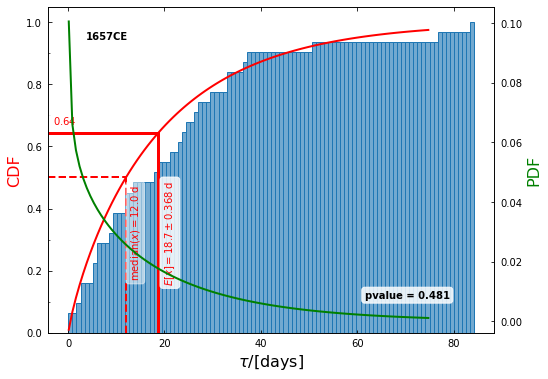

In [6]:
# '03-06-timescales.xlsx'
eruption = '1657CE'
popt, data, se, _ = calc_fit_plot(filename='20210519-sorted-timescales.xlsx', 
                                  sheet_name=eruption, cdf=True, nbins=100,
                                  ppf_tail=.975)
eruption_dict[eruption] = dict(mean=gamma_distn.mean(*popt),
                               med=gamma_distn.median(*popt),
                               se=se[-1])

\newpage

\noindent The 1010 AD eruption data are odd in that there are a few data points at very long times.  Including these completely skews the distribution.  Here, times beyond 4000 days (10.9 years) have been removed.

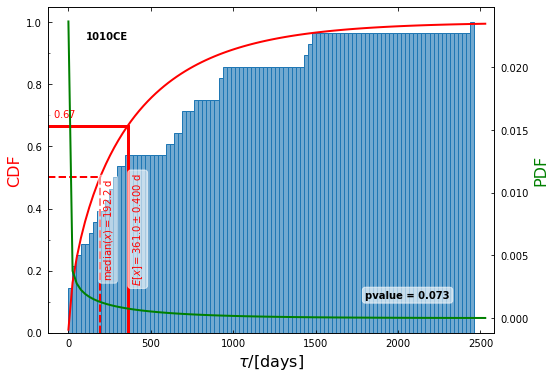

In [7]:
eruption  = '1010CE'
ts_cutoff = None  #2000
popt, data, se, _ = calc_fit_plot(filename='20210519-sorted-timescales.xlsx', 
                                  sheet_name=eruption, cdf=True, nbins=100,
                                  ppf_head=.01, ppf_tail=.995, ts_cutoff=ts_cutoff)
eruption_dict[eruption] = dict(mean=gamma_distn.mean(*popt),
                               med= gamma_distn.median(*popt),
                               se=se[-1])

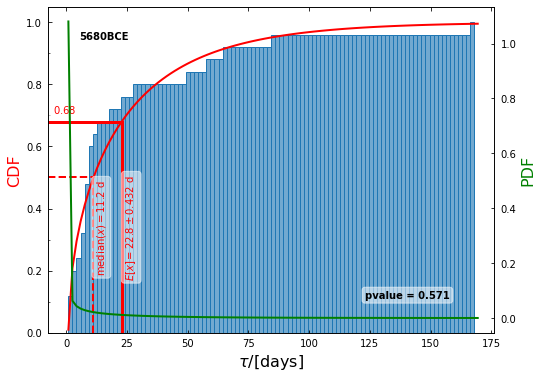

In [8]:
eruption = '5680BCE'
popt, data, se, _ = calc_fit_plot(filename='20210519-sorted-timescales.xlsx', 
                                  sheet_name=eruption, cdf=True, nbins=100,
                                  ppf_head=0.01, ppf_tail=.995)
eruption_dict[eruption] = dict(mean=gamma_distn.mean(*popt),
                               med= gamma_distn.median(*popt),
                               se=se[-1])

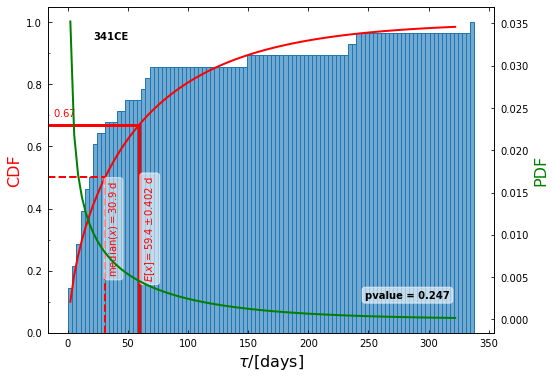

In [9]:
eruption  = '341CE'
ts_cutoff = 2000
popt, data, se, _ = calc_fit_plot(filename='20210519-sorted-timescales.xlsx', 
                                  sheet_name=eruption, cdf=True, nbins=100,
                                  ppf_head=0.10, ppf_tail=.985, ts_cutoff=ts_cutoff)
eruption_dict[eruption] = dict(mean=gamma_distn.mean(*popt),
                               med= gamma_distn.median(*popt),
                               se=se[-1])

In [10]:
# 'se' is a tuple containing the standard errors for the parameter estimates 
# from the fitting of the distribution to the data.  The last entry is the 
# standard error on the timescale.
se

# Table of timescales for all eruptions
timescales_df = pd.DataFrame.from_dict(eruption_dict)
timescales_df.rename({'mean' : 'Expected timescale/[days]', 
                      'med'  : 'Median timescale/[days]',
                      'se'   : 'Timescale std. error/[days]'}, inplace=True)
timescales_df
timescales_df.to_csv('all_timescales.csv', float_format='%.2f')
timescales_df.to_latex('all_timescales.tex', float_format='%.2f')

(0.13130150920582467, 0.003314617713461378, 0.40151720124360946)

,1657CE,1010CE,5680BCE,341CE
Expected timescale/[days],18.75,361.01,22.78,59.36
Median timescale/[days],12.00,192.21,11.20,30.91
Timescale std. error/[days],0.37,0.40,0.43,0.40


In [14]:
# Write this file to a pdf
!jupyter nbconvert --to pdf mineral_diffusion_timescales.ipynb

[NbConvertApp] Converting notebook mineral_diffusion_timescales.ipynb to pdf
[NbConvertApp] Support files will be in mineral_diffusion_timescales_files/
[NbConvertApp] Making directory ./mineral_diffusion_timescales_files
[NbConvertApp] Making directory ./mineral_diffusion_timescales_files
[NbConvertApp] Making directory ./mineral_diffusion_timescales_files
[NbConvertApp] Making directory ./mineral_diffusion_timescales_files
[NbConvertApp] Making directory ./mineral_diffusion_timescales_files
[NbConvertApp] Writing 53696 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 196372 bytes to mineral_diffusion_timescales.pdf
